In [13]:
using Parameters
using Unitful
using LinearAlgebra
import Unitful.ħ, Unitful.me, Unitful.ϵ0
using Roots
using PyPlot
fig_width, fig_height = (8,6)

(8, 6)

In [79]:
@with_kw mutable struct ParamsPlasmon3D
    m0 = 2.5me
    mstar = m0 * 1.04
    mDOS = m0 * (mstar^2 / (mstar^2 - m0^2))^(1 / 3)
    Ef = 0.3u"eV"
    ϵ = 1
end
p = ParamsPlasmon3D()

splitting(p) = abs(ħ^2 * kF(p)^2 / 2mx(1, p) - ħ^2 * kF(p)^2 / 2mx(2, p)) |> u"eV"
@info "Fermi level splitting is " splitting(p)
ϵ(k, σ, p) = ħ^2 * k[1]^2 * (1 / 2p.m0 + σ / 2p.mstar) + ħ^2 * k[2]^2 * (1 / 2p.m0 - σ / 2p.mstar) + ħ^2 * k[3]^2 / 2p.m0
# such that
mx(σ, p) = p.m0 * p.mstar / (p.mstar + σ * p.m0)
my(σ, p) = p.m0 * p.mstar / (p.mstar - σ * p.m0)
mz(p) = p.m0


┌ Info: Fermi level splitting is 
└   splitting(p) = 0.6826740930630635 eV


mz (generic function with 1 method)

In [80]:
kF(p) = sqrt(2p.mDOS * p.Ef) / ħ
N0(p) = p.mDOS * kF(p) / (2 * pi^2 * ħ^2)
n0(p) = 2p.Ef * N0(p)
qprime_squared(q, σ, p) = (
    q[1]^2 * (p.mDOS / mx(σ, p)) + q[2]^2 * (p.mDOS / my(σ, p)) + q[3]^2 * (p.mDOS / mz(p))
)
qprime(q, σ, p) = sqrt(qprime_squared(q, σ, p))
vF(p) = ħ * kF(p) / p.mDOS
ωq(q,p) = (2+exp(4))/(exp(4)) * vF(p) * qprime(q,-1,p)

ωq (generic function with 1 method)

In [81]:
qbar(q, σ, p) = qprime(q, σ, p) / kF(p)
νplus(ω, q, σ, p) = ω / (qprime(q, σ, p) * vF(p)) + qbar(q, σ, p) / 2
νmin(ω, q, σ, p) = ω / (qprime(q, σ, p) * vF(p)) - qbar(q, σ, p) / 2

ωplus(q, σ, p) = ħ * qprime_squared(q, σ, p) / 2p.mDOS + qprime(q, σ, p) * vF(p)
ωminabs(q, σ, p) = abs(ħ * qprime_squared(q, σ, p) / 2p.mDOS - qprime(q, σ, p) * vF(p))
ωmin(q, σ, p) = max(0u"Hz", ħ * qprime_squared(q, σ, p) / 2p.mDOS - qprime(q, σ, p) * vF(p))
flogabs(x) = log(abs((x + 1) / (x - 1)))
function χ0(ω, q, σ, p)
    real_part = 1 / 2 - (1 - νmin(ω, q, σ, p)^2) / 4qbar(q, σ, p) * flogabs(νmin(ω, q, σ, p)) + (1 - νplus(ω, q, σ, p)^2) / 4qbar(q, σ, p) * flogabs(νplus(ω, q, σ, p))

    imag_part = π / 4qbar(q, σ, p) * (
        begin
            1 - νmin(ω, q, σ, p)^2 > 0 ? (1 - νmin(ω, q, σ, p)^2) : 0
        end
        -
        begin
            1 - νplus(ω, q, σ, p)^2 > 0 ? (1 - νplus(ω, q, σ, p)^2) : 0
        end
    )
    -N0(p) * (real_part + 1im * imag_part) |> u"meV^-1 * nm^-3"
end


χ0 (generic function with 1 method)

In [82]:
vq(q, p) = 4π * Unitful.q^2 / (p.ϵ * ϵ0 * norm(q)^2)

function dielectric(ω, q, p)
    1 - vq(q, p) * (χ0(ω, q, 1, p) + χ0(ω, q, -1, p))
end
function S(ω, q, p)
    χ0(ω, q, 1, p) + χ0(ω, q, -1, p)
end
function D(ω, q, p)
    χ0(ω, q, 1, p) - χ0(ω, q, -1, p)
end
function P(ω, q, p)
    χ0(ω, q, 1, p) * χ0(ω, q, -1, p)
end

χnn(ω, q, p) = S(ω, q, p) / dielectric(ω, q, p)
χSzSz(ω, q, p) = (S(ω, q, p) - 4vq(q, p) * P(ω, q, p)) / dielectric(ω, q, p)
χnSz(ω, q, p) = D(ω, q, p) / dielectric(ω, q, p)

χnSz (generic function with 1 method)

In [83]:
function find_pole(q, p)
    f = x -> dielectric(x * p.Ef / ħ, q, p) |> real
    ω0 = min(ωplus(q, -1, p), ωplus(q, 1, p)) * 1.2 / (p.Ef / ħ)
    find_zero(f, ω0) * (p.Ef / ħ)
end

find_pole (generic function with 1 method)

In [84]:
# D_psi = z -> -(z/(-1 + z^2)) + 1/2 *log((1 + z)/(-1 + z))

D_psi = z -> 1 - z / 2 * log((z+1)/(z-1)) 


function D_full(ω, q, σ, p)
    (qprime(q,-1,p) * vF(p) )^-1 / qbar(q,-1,p)* (
    D_psi(ω / (qprime(q,-1,p) * vF(p)) + 1e-6im - qprime(q,-1,p)/2kF(p)) -
    D_psi(ω / (qprime(q,-1,p) * vF(p)) + 1e-6im + qprime(q,-1,p)/2kF(p))
        )
end

D_full (generic function with 1 method)

In [85]:
Ψprime(z) = 1 - z/2 * log((z+1)/(z-1))
χlim(ω, q, σ, p) = -N0(p) * Ψprime(ω / (qprime(q,σ,p) * vF(p))-1e-5im)
χlim_simple(ω, q, σ, p) = -N0(p) * (1 - (ω / (qprime(q,σ,p) * vF(p)))^2 )#- 1/3 * (ω / (qprime(q,σ,p) * vF(p)))^4)

χlim_simple (generic function with 1 method)

Now we have zeros of the dielectric function if $\chi^\uparrow+\chi^\downarrow=0$, so take a look at this:

In [70]:
vF(p) * q *  2 / sqrt(3) * (ħ / p.Ef) |> upreferred

0.11547005383792516

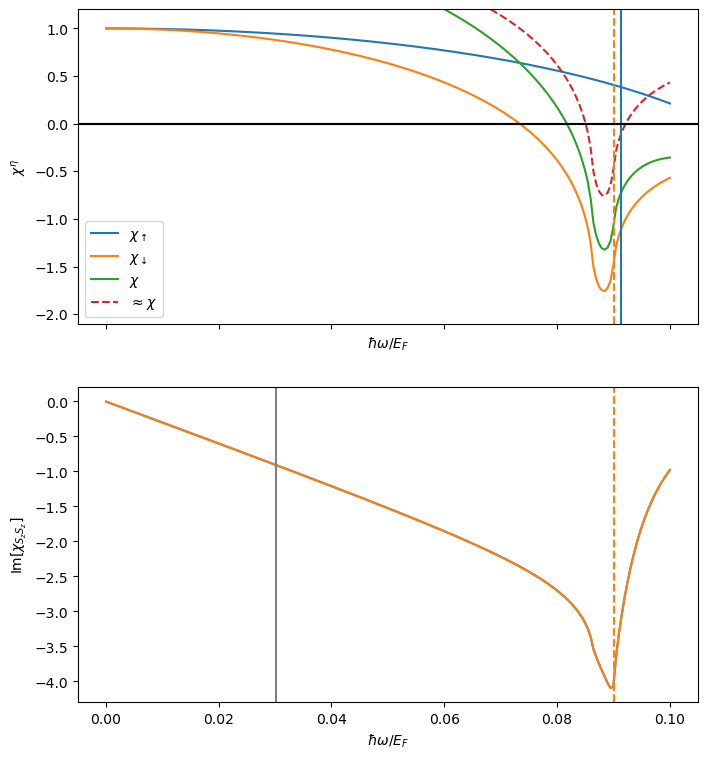

PyObject Text(29.08, 0.5, '$\\mathrm{Im}[\\chi_{S_zS_z}]$')

In [90]:
Nω = 200
ωrange = range(0.0001p.Ef / ħ, stop=0.1p.Ef / ħ, length=Nω)
fq = q -> [0.6q, 0.4q, 0q]

q = 0.05kF(p)
fig, axs = plt.subplots(2,1,figsize=(fig_width, 1.5fig_height), sharex=true)
ax = axs[1]
resup = [-((χ0(ω, fq(q), 1, p))) / N0(p) for ω in ωrange] .|> upreferred
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resup .|> ustrip .|> real, label=L"\chi_\uparrow")
resdown = [-((χ0(ω, fq(q), -1, p)))/ N0(p) for ω in ωrange] .|> upreferred
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resdown .|> ustrip .|> real, label=L"\chi_\downarrow")
# resdown_approx = [-((n0(p) * qprime_squared(fq(q), -1, p) / (p.mDOS * ω^2)) * (1 + 3 / 5 * qprime_squared(fq(q), -1, p) * vF(p)^2 / ω^2)) for ω in ωrange] .|> upreferred

# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, (resdown_approx .+ N0(p)) .|> ustrip .|> real, label=L"\approx \chi")

ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, (resdown .+ resup) .|> ustrip .|> real, label=L"\chi")

resdown_approx = [-(n0(p) * qprime_squared(fq(q), -1, p) / (p.mDOS * ω^2)) / N0(p) for ω in ωrange] .|> upreferred
# resdown_approx = [-χlim_simple(ω, fq(q), -1, p) / N0(p) for ω in ωrange] .|> upreferred

# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resdown_approx .|> ustrip .|> real, "--",label=L"\approx \chi_\downarrow")
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, (resdown .+ 1) .|> ustrip .|> real, "--", label=L"\approx\chi")


ax.axhline(vq(fq(q), p) |> upreferred |> ustrip)
# ax.axvline(ωplus(fq(q), 1, p) * ħ / p.Ef, linestyle="-", color="C0")
ax.axvline(ωplus(fq(q), -1, p) * ħ / p.Ef, linestyle="--", color="C1")

# ax.axvline(ωminabs(fq(q), 1, p) * ħ / p.Ef, linestyle="-.", color="C0")
# ax.axvline(ωminabs(fq(q), -1, p) * ħ / p.Ef, linestyle="-.", color="C1")
# ax.axvline(find_pole(fq(q),p) /  (p.Ef / ħ) |> upreferred, color="black", linestyle="-")
ax.axvline(ωq(fq(q),p) * (ħ / p.Ef) |> upreferred) #, linestyle="-", color="grey")
ax.axhline(0, color="black")
ax.legend()
ax.set_xlabel(L"\hbar\omega/E_F")
ax.set_ylabel(L"\chi^\eta")
ax.set_ylim(1.2.*extrema(resdown .|> ustrip .|> real)...)

ax = axs[2]
resSzSz = [((χSzSz(ω, fq(q), p))) / N0(p) for ω in ωrange] .|> upreferred
# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, -(resup + resdown).^-1 .|> ustrip .|> imag)
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resSzSz .|> ustrip .|> imag)
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, -4(resup .* resdown) ./ (resup + resdown) .|> ustrip .|> imag)
# ax.axvline(find_pole(fq(q),p) /  (p.Ef / ħ) |> upreferred, color="black", linestyle="-")
ax.axvline(sqrt(n0(p) * q^2 / (mx(-1,p) * N0(p)) ) * (ħ / p.Ef) |> upreferred, linestyle="-", color="grey")

# ax.axvline(ωplus(fq(q), 1, p) * ħ / p.Ef, linestyle="-", color="C0")
ax.axvline(ωplus(fq(q), -1, p) * ħ / p.Ef, linestyle="--", color="C1")

# ax.axvline(ωminabs(fq(q), 1, p) * ħ / p.Ef, linestyle="-.", color="C0")
# ax.axvline(ωminabs(fq(q), -1, p) * ħ / p.Ef, linestyle="-.", color="C1")

ax.set_xlabel(L"\hbar\omega/E_F")
ax.set_ylabel(L"\mathrm{Im}[\chi_{S_zS_z}]")


In [59]:
@info (2+exp(4))/(exp(4))
@info 1 + 2 / exp(4)

[ Info: 1.0366312777774684
[ Info: 1.0366312777774684


Determine the derivative by hand

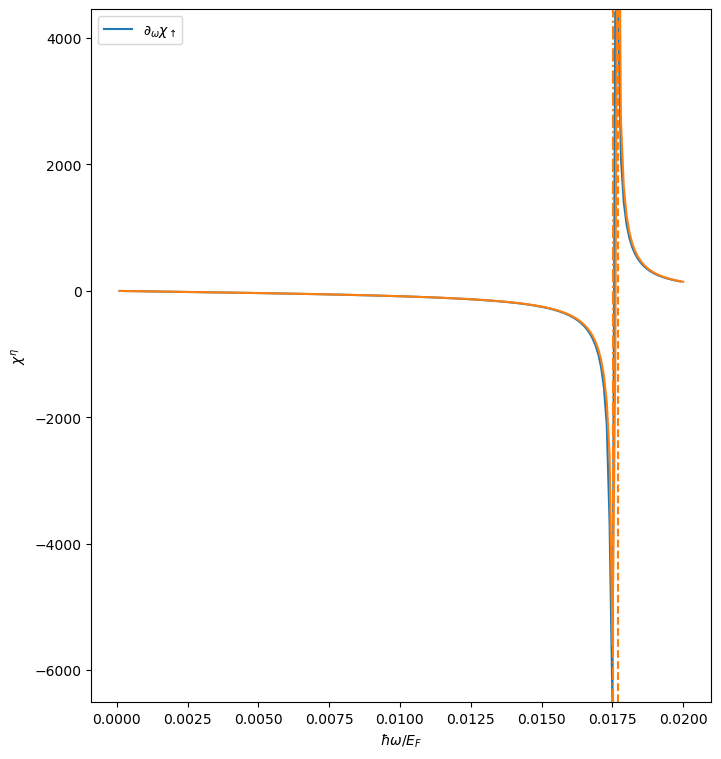

(-6506.235546434505, 4452.425040199186)

In [92]:
Nω = 200
ωrange = range(0.0001p.Ef / ħ, stop=0.02p.Ef / ħ, length=Nω)

q = 0.01kF(p)
fig, ax = plt.subplots(1,1,figsize=(fig_width, 1.5fig_height), sharex=true)
resup = [-((χ0(ω, fq(q), -1, p))) / N0(p) for ω in ωrange] .|> upreferred

dω = (ωrange[2] - ωrange[1]) * ħ / p.Ef 
D_up_numerical = [(resup[i+1]-resup[i]) / dω for i in 1:Nω-1]

ax.plot(ωrange[1:end-1] .* ħ ./ p.Ef .|> upreferred, D_up_numerical .|> ustrip .|> real, label=L"\partial_\omega\chi_\uparrow")


# resup_diff = [2n0(p) * qprime_squared(fq(q),-1,p) / (p.mDOS * ω^3) / N0(p) /(ħ / p.Ef) for ω in ωrange] .|> upreferred


# resup_diff = [1 - n0(p) * qprime_squared(fq(q),-1,p) / (p.mDOS * ω^2) / N0(p)  for ω in ωrange] .|> upreferred

# resup_diff = [-(qprime(fq(q),-1,p) * vF(p))^-1*D_psi(ω / (qprime(fq(q),-1,p) * vF(p)) + 1e-6im) /(ħ / p.Ef) for ω in ωrange] .|> upreferred


resup_diff = [-D_full(ω, fq(q), 1,p) /(ħ / p.Ef) for ω in ωrange] .|> upreferred

ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resup_diff .|> real)
# ax.axvline(ωplus(fq(q), 1, p) * ħ / p.Ef, linestyle="-", color="C0")
ax.axvline(ωplus(fq(q), -1, p) * ħ / p.Ef, linestyle="--", color="C1")

# ax.axvline(ωminabs(fq(q), 1, p) * ħ / p.Ef, linestyle="-.", color="C0")
ax.axvline(ωminabs(fq(q), -1, p) * ħ / p.Ef, linestyle="-.", color="C1")

# ax.axvline(ωs(fq(q)) * ħ / p.Ef, linestyle="-", color="grey")
# ax.axhline(0, color="black")
ax.legend()
ax.set_xlabel(L"\hbar\omega/E_F")
ax.set_ylabel(L"\chi^\eta")
# ax.set_ylim(extrema(resdown .|> ustrip .|> real)...)
ax.set_ylim(extrema(D_up_numerical .|> real)...)

Now we can directly determine the quality factor

In [200]:
function γ(ω, q, p)
    imag(χ0(ω, q, 1, p) + χ0(ω, q, -1, p)) / (D_full(ω, q, 1, p) + D_full(ω, q, -1, p)) / N0(p) |> upreferred
end

@info find_pole(fq(q),p) / (γ(find_pole(fq(q),p), fq(q),p)) |> upreferred
@info ωq(fq(q),p) / γ(ωq(fq(q),p),fq(q),p) |> upreferred

[ Info: 170.37243321024528 - 0.004271684299713516im
[ Info: 215.94801659558485 - 0.006601904311414946im


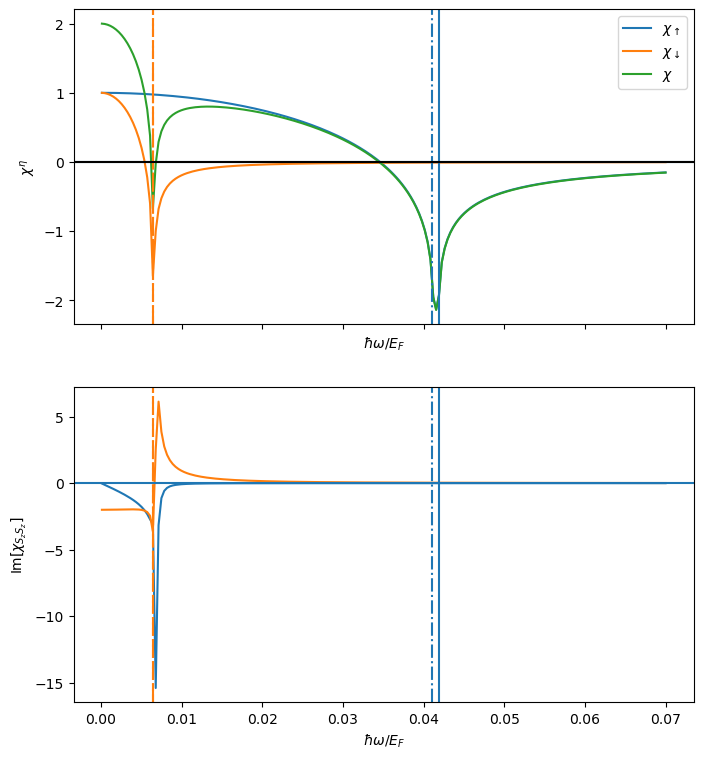

PyObject Text(29.08, 0.5, '$\\mathrm{Im}[\\chi_{S_zS_z}]$')

In [157]:
p  = ParamsPlasmon3D()
Nω = 200
ωrange = range(0.0001p.Ef / ħ, stop=0.07p.Ef / ħ, length=Nω)

q = 0.01kF(p)
fig, axs = plt.subplots(2,1,figsize=(fig_width, 1.5fig_height), sharex=true)
ax = axs[1]
resup = [-((χ0(ω, fq(q), 1, p))) / N0(p) for ω in ωrange] .|> upreferred
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resup .|> ustrip .|> real, label=L"\chi_\uparrow")
resdown = [-((χ0(ω, fq(q), -1, p)))/ N0(p) for ω in ωrange] .|> upreferred
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resdown .|> ustrip .|> real, label=L"\chi_\downarrow")
# resdown_approx = [-((n0(p) * qprime_squared(fq(q), -1, p) / (p.mDOS * ω^2)) * (1 + 3 / 5 * qprime_squared(fq(q), -1, p) * vF(p)^2 / ω^2)) for ω in ωrange] .|> upreferred

# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, (resdown_approx .+ N0(p)) .|> ustrip .|> real, label=L"\approx \chi")
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, (resdown .+ resup) .|> ustrip .|> real, label=L"\chi")

# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, (resdown .+ resup) .* imag.(resdown .+ resup) .|> ustrip .|> real, label=L"\chi_z")

ax.axhline(vq(fq(q), p) |> upreferred |> ustrip)
ax.axvline(ωplus(fq(q), 1, p) * ħ / p.Ef, linestyle="-", color="C0")
ax.axvline(ωplus(fq(q), -1, p) * ħ / p.Ef, linestyle="--", color="C1")

ax.axvline(ωminabs(fq(q), 1, p) * ħ / p.Ef, linestyle="-.", color="C0")
ax.axvline(ωminabs(fq(q), -1, p) * ħ / p.Ef, linestyle="-.", color="C1")

# ax.axvline(ωs(fq(q)) * ħ / p.Ef, linestyle="-", color="grey")
ax.axhline(0, color="black")
ax.legend()
ax.set_xlabel(L"\hbar\omega/E_F")
ax.set_ylabel(L"\chi^\eta")
# ax.set_ylim(extrema(resdown .|> ustrip .|> real)...)

ax = axs[2]
resSzSz = [((χSzSz(ω, fq(q), p))) / N0(p) for ω in ωrange] .|> upreferred
# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, -(resup + resdown).^-1 .|> ustrip .|> imag)
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resSzSz .|> ustrip .|> imag)
ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, resSzSz .|> real)
ax.axhline(0)
# ax.plot(ωrange .* ħ ./ p.Ef .|> upreferred, -4(resup .* resdown).|> ustrip .|> real)

ax.axvline(ωplus(fq(q), 1, p) * ħ / p.Ef, linestyle="-", color="C0")
ax.axvline(ωplus(fq(q), -1, p) * ħ / p.Ef, linestyle="--", color="C1")

ax.axvline(ωminabs(fq(q), 1, p) * ħ / p.Ef, linestyle="-.", color="C0")
ax.axvline(ωminabs(fq(q), -1, p) * ħ / p.Ef, linestyle="-.", color="C1")

ax.set_xlabel(L"\hbar\omega/E_F")
ax.set_ylabel(L"\mathrm{Im}[\chi_{S_zS_z}]")